# Cropping digits for analog

This notebook is intended to provide functions to process the images of analog number, particularly the HQ ones.
The final output is a hierarchy of folder where the crops of each digit in the images are stored.

Packages

In [1]:
import cv2
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.cluster import KMeans

%matplotlib inline

List of support functions

In [2]:
def sort_contours(cnts, method="left-to-right"):
    '''
    Function to sort contours based on x-position
        cnts -- list of contours
        method -- direction of x in which we want to order
    
    returns list of contours sorted
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to bottom
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, bounding_boxes) = zip(*sorted(zip(cnts, bounding_boxes),
                                         key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return cnts


#Clustering method 1: 
def Cluster(areas: list):
    '''
    Function to cluster in undefined number of clusters based on areas. 
    The threshold is the standard deviation of the areas.
        areas -- list of areas
    
    returns list of lists with index of contours. Each sub-list is a cluster
    '''
    def group_elements(element: int, index: int, group: list):
        if visited[element]: 
            # If we visited the element, we stop
            return
        visited[element] = True #Mark as visited
        group.append((element, index)) #add as part of the group
        for another, j in connections[element]: #Recurse for other elements
            group_elements(another,j, group)

    std_area = np.std(areas)
    connections = {}
    visited = {}
    # Creating dictionary. 
    # Key = area ; Value= list of areas where diff with Key is less than standard deviation
    for i,area in enumerate(areas):
        connections[area] = []
        visited[area] = False
        for j,another in enumerate(areas):
            if abs(area - another) <= std_area:
                connections[area].append((another, j))

    groups = []
    for i,area in enumerate(areas):
        if not visited[area]:
            group = []
            group_elements(area,i, group)
            groups.append(group)
            
    return [[el[1] for el in groups[i]] for i in range(len(groups))] 

#Clustering method 2: 
def Cluster2(ar: list):
    '''
    Function to cluster array using KMeans. 
    We fix the number of cluster as 2, based on heuristics of when this function will be used.
        ar -- array of numbers to cluster
    
    Returns list of lists with index of clusters
    '''
    # Sometimes it is possible to not find 2 groups, then we return original array
    try:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(ar).reshape(-1, 1))
        cluster1 = []
        cluster2 = []
        for i, el in enumerate(kmeans.labels_): #Splitting by cluster found
            if el == 0:
                cluster1.append(i)
            else:
                cluster2. append(i)
        return([cluster1, cluster2])
    
    except:
        return [list(range(len(ar)))]
    
def clustering_stats(clusters, potential_cnt):
    '''
    Given clusters and contours, returns avg height and y-location of boxes and their standard deviation
    
        clusters -- list of lists with indexes of boxes within same cluster
        potential_cnt -- list of contours
    '''
    cluster_stats = [] 
    # Computing height and location of each area
    for cluster in clusters:
        heights = []
        h_locations = []
        
        for i in cluster:
            contour = potential_cnt[i]
            [x, y, w, h] = cv2.boundingRect(contour)
            heights.append(h)
            h_locations.append((2*y+h)/2)

        avg_height = np.mean(heights)
        std_height = np.std(heights)
        avg_location = np.mean(h_locations)
        std_location = np.std(h_locations)
        cluster_stats.append([avg_height, std_height, avg_location, std_location])
        
    return cluster_stats
    
# Creation of bounding boxes based on already found ones
def createBox(new_boxes: list):
    '''
    Function to create bounding boxes out of digits already found.
    new_boxes: list of lists. Each sublist represents the corners of a found box
    
    Returns list of lists. Adding to original boxes extra boxes based on rules.
    '''
    # Extracting the coordinates of boxes in separate lists
    yLocations = [new_boxes[i][0] for i in range(len(new_boxes))] # y-coordinate of top-left corners
    yLocations_ = [new_boxes[i][1] for i in range(len(new_boxes))] # y-coord of bottom right corners
    heights = [new_boxes[i][1] - new_boxes[i][0] for i in range(len(new_boxes))] # Heights of boxes

    xLocations = [new_boxes[i][2] for i in range(len(new_boxes))] # x-coordinate of top-left corners
    xLocations_ = [new_boxes[i][3] for i in range(len(new_boxes))] # x-coord of bottom right corners
    widths = [new_boxes[i][3] - new_boxes[i][2] for i in range(len(new_boxes))]# Width of boxes
    
    dists = [] #List to save horizontal distances between boxes
    
    # If there is only 1 found digit, we create boxes on left and right until it doesn't fit anymore
    if len(xLocations) == 1: 
        max_width = max(widths)
        minY = min(yLocations)
        maxHeight = max(heights)
        
        # If can fit a digit on the leftmost
        while min(xLocations) - 2*max_width >= 0:
            newX = min(xLocations) - 2*max_width 
            new_boxes.append([minY*0.8, minY + maxHeight*1.3, newX, newX + max_width])
            xLocations.append(newX)

        # If can fit a digit on the rightmost
        while max(xLocations_) + 2*max_width < image.shape[1]:
            newX = max(xLocations_) + 1.35*max_width
            new_boxes.append([minY*0.8, minY + maxHeight*1.3, newX, newX + max_width])
            xLocations_.append(newX + max_width)
        return new_boxes
    
    elif len(xLocations) < 1: #If there are no boxes found, we return empty list
        return new_boxes
    
    # ------------ In any other situation we apply rules to enforce boxes ------------
    # Finding horizontal distances among boxes found
    for i in range(1,len(xLocations)):
        dists.append(xLocations[i] - xLocations_[i-1])
    
    max_width = max(widths)
    min_dist = min([dists[i] for i in range(len(dists)) if dists[i] > 0])
    minY = min(yLocations)
    maxHeight = max(heights)
    
    # If can fit digit on leftmost:have room for the sum of minimum distance among boxes found + max(box width)
    while min(xLocations) - (min_dist + 1.02*max_width) >= 0:
        newX = min(xLocations) - (min_dist + 1.02*max_width)
        new_boxes.append([minY*0.9, minY + maxHeight*1.1, newX, newX + max_width*1.02])
        xLocations.append(newX)

    # If can fit digit on rightmost:have room for the sum of minimum distance among boxes found + max(box width)
    while max(xLocations_) + 1.02*(min_dist + max_width) < image.shape[1]:
        newX = max(xLocations_) + (min_dist)
        new_boxes.append([minY*0.9, minY + maxHeight*1.1, newX, newX + max_width*1.02])
        xLocations_.append(newX + max_width*1.02)

    # If can fit a digit in between two boxes: more than 1.8 the max width
    for i,dist in enumerate(dists): 
        if dist > 1.8* max_width:
            ratio = (xLocations_[i] - xLocations[i])/(yLocations_[i] - yLocations[i])
            # The rules depend on the ratio of the number on the left:
            # If it is probably a 1 then
            if ratio < 0.4:
                margin = (dist - max_width)/2
                newX = xLocations_[i] + 5/4*min(margin, min_dist)
                new_boxes.append([minY*0.9, minY + maxHeight*1.1, newX, newX + max_width])
            else: # If the number on the left is probably NOT a 1 then
                margin = (dist - max_width)/2
                newX = xLocations_[i] + min(margin, min_dist)
                new_boxes.append([minY*0.9, minY + maxHeight*1.1, newX, newX + max_width])
    return new_boxes


In [5]:
def processing(image: list):
    '''
    Function to process Analog images.
        image -- tensor with the image pixel values
    Returns list of boxes which contains digits
    '''
    # ----------------------------- IMAGE PROCESSING --------------------------------
    # Image size
    image_size = image.shape[0] * image.shape[1] 
    
    # Adjust the exposure
    exposure = 1 
    image2 = cv2.multiply(image, np.array([float(exposure)]))
    
    # Convert to grayscale
    image3 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # Blur to reduce noise
    blur = 9
    image4 = cv2.GaussianBlur(image3, (blur, blur), 0)

    # Adaptive Thresholding the image
    threshold = 201
    adjustment = -15
    image5 = cv2.adaptiveThreshold(image4, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                                      threshold, adjustment)
    
    # Blur to reduce noise
    blur = 17
    image6 = cv2.GaussianBlur(image5, (blur, blur), 0)
    
    # Erode the lcd digits to make them continuous for easier contouring
    erode = 3
    iterations = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (erode, erode))
    image7 = cv2.erode(image6, kernel, iterations=iterations)
    #imshow(image7, cmap = "gray")
    
    # ----------------------FIND CONTOURS OF 0-9/{1} ----------------------
    #First, we search for digits that are not 1, since they have similar proportions
    contours, _ = cv2.findContours(image7, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # get contours

    # Assuming we find some, we'll sort them in order left -> right
    if len(contours) > 0:
        contours = sort_contours(contours)
    
    areas = []
    potential_cnt = []
    new_image = image.copy()
    nbr_ratio = 0.6 # heuristic ratio of non-1 digits
    
    #------COUNTOURS BY RATIO-----
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour) # Get corners coord
        ratio = w/h
        # Keep contours if:
        #    1- Ratios is within a range
        #    2- Area of box is smaller than 40% of the whole image size
        if (ratio <= nbr_ratio + 0.25 and ratio >= nbr_ratio - 0.1) \
            and w*h < 0.4*image_size: 
                areas.append(w * h)
                potential_cnt.append(contour) # Remaining potential contour list
    
    # -----CLUSTERING BOXES BY AREA: diff in area smaller than 1 standard deviation of all areas------
    clusters = Cluster(areas)
    #print([[cv2.boundingRect(potential_cnt[i])[0] for i in cluster] for cluster in clusters])
    cluster_stats = clustering_stats(clusters, potential_cnt)
    
    tempContours = []
    tempArea = []
    tempHeight = []
    tempLocation = []
    
    boxes = []
    for i,contour in enumerate(potential_cnt):
        [x, y, w, h] = cv2.boundingRect(contour)

        for j, cluster in enumerate(clusters): # Search in which cluster our contour falls in
            if i in cluster:
                category = j
                break
        # Keep contour if:
        #    1- Height of box is no bigger/smaller than 2 times the standard deviation of the class average
        #    2- Mean Y-coord of box no bigger/smaller than 2 times the standard deviation of the class average
        #       (numbers more or less aligned in Y)
        #    3- The standard deviation of the class is at most 0.3 times the class average 
        if (h <= cluster_stats[category][0] + 2*cluster_stats[category][1] \
                and h >= cluster_stats[category][0] - 2*cluster_stats[category][1]) \
            and cluster_stats[category][3] < 0.3* cluster_stats[category][2] \
            and ((2*y+h)/2 <= cluster_stats[category][2] + 2*cluster_stats[category][3] \
                and(2*y+h)/2 >= cluster_stats[category][2] - 2*cluster_stats[category][3]):
                tempContours.append(contour)
                tempArea.append(w*h)
                tempHeight.append(h)
                tempLocation.append((2*y+h)/2)

                boxes.append([y , y+h, x , x+w])
    # ^^^^^^^^^^^^^^^^^^^^^^ Find contours of 0-9/{1} ^^^^^^^^^^^^^^^^^^^^^^
    # ---------------------- FIND CONTOURS OF 1 ----------------------------
    # Number 1 has a really different ratio than other digits. 
    # Since it is easy box straight lines, we mainly do this step to enforce condition in area
    one_ratio = 0.2 # Heuristic number 1 ratio
    
    tempArea_avg = np.mean(tempArea)
    tempHeight_avg = np.mean(tempHeight)
    tempHeight_std = np.std(tempHeight)
    tempLocation_avg = np.mean(tempLocation)
    tempLocation_std = np.std(tempLocation)
    
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        ratio = w/h
        area = w*h
        # Keep contour if:
        #    1- Ratio is inside certain range
        #    2- Area has to be smaller than others boxes found (inside a range)
        #    3- Height of box is no bigger/smaller than 2 times the standard deviation of boxes found
        #    4- Mean Y-coord of box no bigger/smaller than 2 times the standard deviation of boxes found
        if (ratio <= one_ratio + 0.2 and ratio >= one_ratio - 0.1) \
            and (area <= 0.8*tempArea_avg and area >= 0.15* tempArea_avg) \
            and (h <= tempHeight_avg + 2*tempHeight_std and h >= tempHeight_avg - 2*tempHeight_std) \
            and ( 2*y+h <= 2*(tempLocation_avg + 2*tempLocation_std) \
                 and 2*y+h >= 2*(tempLocation_avg - 2*tempLocation_std) ):
                boxes.append([y , y+h, x , x+w])
    # ^^^^^^^^^^^^^^^^^^^^^^ Find contours of 1 ^^^^^^^^^^^^^^^^^^^^^^
    
    # ---------------------- EXTRA CONDITIONS TO FILTER BOXES ----------------------------------
    # ------ Clustering boxes by Y-axis ----------
    yLoc = [box[0] for box in boxes] + [-1] # Adding -1 to have always a 2nd cluster 
    clusters = Cluster2(yLoc)  
    new_boxes = []
    for cluster in clusters:
        if len(cluster) == max(map(len, clusters)): # Select the cluster with max number of elements
            for index in cluster:
                if index < len(boxes): # To make sure that dummy height(-1) included on yLoc is not selected
                    new_boxes.append(boxes[index])
            break
    
    # ---------- If we still have more than 5 boxes, filter out by area --------------
    if len(new_boxes) > 5:
        areas = []
        for i, box in enumerate(new_boxes):
            areas.append(((box[1] - box[0])*(box[3] - box[2]), i))
        areas_sorted = sorted(areas, key= lambda x: x[0], reverse= True)[:5] #Selected 5 biggest areas
        indexes = [areas_sorted[i][1] for i in range(5)]
        new_boxes = [new_boxes[i] for i in indexes] 
      
        # Remove boxes, where area are smaller than standard deviation of the top 5 areas
        area_std = np.std([areas_sorted[i][0] for i in range(len(areas_sorted))])
        new_boxes_ = []
        for i in range(len(areas_sorted)):
            if area_std/areas_sorted[i][0] < 1:
                new_boxes_.append(new_boxes[i])
        new_boxes = new_boxes_.copy()

    #------- If we have less than 5 boxes, there are more missing probably: Impose boxes -----------
    if len(new_boxes) < 5:
        new_boxes = createBox(sorted(new_boxes, key = lambda x: x[2]))
    # ^^^^^^^^^^^^^^^^^^^^^^
    
    # Increasing size of the boxes to increase confidence
    new_boxes = [
        [
            int(new_boxes[i][j]*0.98) 
            if j%2 == 0
            else int(new_boxes[i][j]*1.02)
            for j in range(4)
         ]
        for i in range(len(new_boxes))
    ]
    # Return sorted list of boxes based on X-axis
    return sorted(new_boxes, key = lambda x: x[2])


Simple example

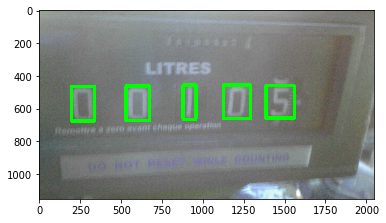

In [8]:
image = cv2.imread(example_file)

boxes = processing(image)

for i in range(len(boxes)):
    tempImage = cv2.rectangle(image,(boxes[i][2],boxes[i][0]),(boxes[i][3],boxes[i][1]),(0,255,0),20)
imshow(tempImage)

Code to read the original images and output a hierarchy of folder with the numbers cropped